<h3 style="text-align:center; font-size:36px; color:black; font-weight:bold"> Default Credit Score Case</h3>
<h3 style="text-align:center; font-size:26px; color:black">Predictive Analytics</h3>

---

Previously in *Analytics.ipynb* we performed a logistic regression analysis in order to understand the business problem and  the profile of clients in default. Now our objective is to make a predictive model to classify a set of unclissified clients into default and non default in order to start a publicitary campaing to offer some baking products such as credit cards, loans and etc.

A set of predictive models will be trained and the best one will be chosen.

---

# 1. Loading Required Libraries

In [13]:
import os as os
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import log_loss, RocCurveDisplay, PrecisionRecallDisplay, confusion_matrix, recall_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

---

# 2. Loading the training database

In [2]:
file = os.path.join('data','processed_dataframe.csv')
try:
    df = pd.read_csv(file)
    print(f' data frame: {file} read')
except:
    print(f'error in loading dataframe, verify the path or file {file}')

 data frame: data\processed_dataframe.csv read


---

# 3. Splitting the data set into trainig and testing data sets

As shown in previous analysis (see *EDA.ipynb* and *Analytics.ipynb*) the target class (Default clients) represent only about 5% of the total of clients. So, to lead with this imbalance we will use SMOTE algorithm to overcome the class imbalance.

## 3.1. Splitting the data into training and testing sets

We will divide the sets in the proportion, training set: 80% and testing set: 20%.

In [3]:
# Getting features and target
X = df[['UIS','age','RDW','MW','NTD3059','NTD6089','NTDGT90','NB','ND','OCL']]
y = np.array(df[['Default']])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=92)

## 3.2. Verifying proportion of target in training and testing sets

In [4]:
print('--------------------------------------------------------------')
print(f'Proportion of Default target in training set: {round(y_train.mean(),3)}')
print(f'Proportion of Default target in testing set : {round(y_test.mean(),3)}')
print('--------------------------------------------------------------')

--------------------------------------------------------------
Proportion of Default target in training set: 0.058
Proportion of Default target in testing set : 0.059
--------------------------------------------------------------


As we can see both the training and testing sets have proportions of default near each other, this is just a verification of the sampling process.

## 3.3. SMOTE resampling 

To overcome the class imbalance, we will use SMOTE oversampling (it oversamples the less proportional target category) technique to balance both classes in training set.

In [5]:
# Apply SMOTE to the training set

smote = SMOTE(sampling_strategy = 'not majority', random_state=102)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print('--------------------------------------------------------------')
print(f'Proportion of Default target in training set atfer SMOTE: {round(y_train_resampled.mean(),3)}')
print('--------------------------------------------------------------')

--------------------------------------------------------------
Proportion of Default target in training set atfer SMOTE: 0.5
--------------------------------------------------------------


---

# 4. Model Random Forest Classifier

None data transformation is necessary to be applied in this model, the only thing that it is needed to be assumed is independece among observations, once our study is a snapshot of the database, i.e. data sampled at a given timestamp, the constraint of independence is satisfied.

## 4.1. Model Tuning

Following *Hastie, Tibshrany and Friedman*, for classificaton problems it is advised that the depths of the trees have a maximum depth around the square root of the number of covariates or features (10), rounding square root of 10, we choose 4 as the max_depth hyperparameter.

Another hyperparameter is the number of estimators or number of trees in the forest that we will be tune.

In [6]:
%%time

# Random Forest Model
rf_model = RandomForestClassifier(max_depth = 4, bootstrap=True, oob_score=False,  
                                  n_jobs = -1, random_state=0, warm_start = True)

# Training various models to get the best number of trees or estimators
cross_entropy_loss = []
for n_estimator in range(1,500):
    rf_model.n_estimators = n_estimator
    rf_model.fit( X_train_resampled, y_train_resampled )
    y_pred = rf_model.predict(X_test)
    cross_entropy_loss += [log_loss(y_test, y_pred)]

Wall time: 3min 12s


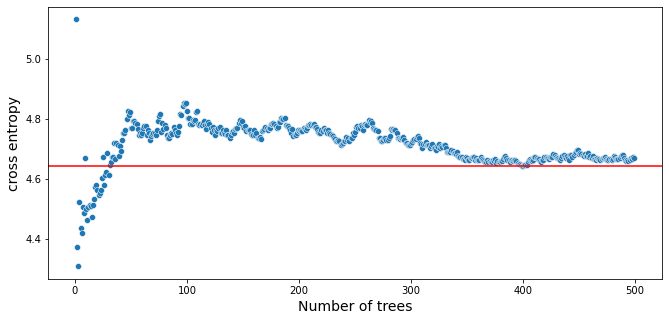

In [7]:
fig = plt.figure(figsize=(11, 5))
sns.scatterplot(x=range(1,500), y=cross_entropy_loss)
plt.axhline(y = np.min(cross_entropy_loss[100:]), color='red')
plt.xlabel('Number of trees', size=14)
plt.ylabel('cross entropy', size=14)
plt.show()

A curve representing the number of trees and the cross entropy is presented above. We can see a convergence of the cross entropy after about 400 trees, so we will tune the number of estimators of the Randon Forest algorithm as 400 trees

## 4.2. Model Training

In [8]:
# Random Forest Model
rf_model = RandomForestClassifier(n_estimators = 400, max_depth = 4, bootstrap=True, 
                                  oob_score=False, n_jobs = -1, random_state=0)

# Training the Model
rf_model.fit( X_train_resampled, y_train_resampled )

# Evaluating the testing set
y_pred_proba = rf_model.predict_proba(X_test)
y_pred = rf_model.predict(X_test)

### ROC curve & AUC statistic

Text(0.5, 1.0, 'Testing Set')

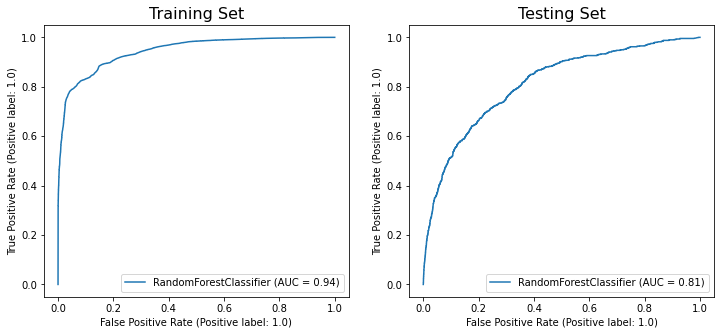

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

RocCurveDisplay.from_estimator(rf_model, X_train_resampled, y_train_resampled, ax=ax[0])
ax[0].set_title('Training Set', size=16)
RocCurveDisplay.from_estimator(rf_model, X_test, y_test, ax=ax[1])
ax[1].set_title('Testing Set', size=16)

The Receiver Operator Characteristic (ROC) curve is shown above for both the training and testing sets and their Area Under the Curve (AUC) statistic are 0.94 and 0.81, these values indicates that the model has a good performance.

In [16]:
acc_train= accuracy_score(y_train_resampled, rf_model.predict(X_train_resampled) )
acc_test = accuracy_score(y_test, y_pred)

rec_train = recall_score(y_train_resampled, rf_model.predict(X_train_resampled) )
rec_test = recall_score(y_test, y_pred)

print('-------------------------------------')
print(f'Accuracy training set:   {acc_train.round(2)}')
print(f'Accuracy testing set:    {acc_test.round(2)}')
print('')
print(f'Recall training set:     {rec_train.round(2)}')
print(f'Recall testing set:      {rec_test.round(2)}')
print('-------------------------------------')

-------------------------------------
Accuracy training set:   0.86
Accuracy testing set:    0.87

Recall training set:     0.84
Recall testing set:      0.53
-------------------------------------


Due to the low proportion of default clients in the testing set (a common characteristic of this kind of problem), the recall statistics in testing set is low, to get better classification, we need to tune the threshold (by default it is 0.5).

Before this, let us look at the confusion matrices of training and testing sets

### Confusion Matrix and Threshold

In [10]:
print('Training Set, Threshold>0.5')
print( pd.DataFrame(confusion_matrix(y_train_resampled, rf_model.predict(X_train_resampled))) )
9
print('\nTesting Set, Threshold>0.5')
print( pd.DataFrame(confusion_matrix(y_test, y_pred)) )

Training Set, Threshold>0.5
       0      1
0  50800   6397
1   9314  47883

Testing Set, Threshold>0.5
       0     1
0  12747  1539
1    417   478


As we can see, for the testing set, the confusion matrix for the target 1, presents high false positive and true negative rates, to overcome this, we will try to find an optimal value satisfying the follwng function:

<center> L = 3&times;TPR + 1&times;TNR - 3&times;FPR - 1&times;FNR </center>
<br>
wherein false positive rate and false negative rate have penalization 3 and 1 respectively.

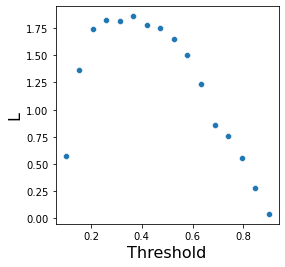

In [61]:
y_trg = np.array([y[1] for y in y_pred_proba])
thresholds = np.linspace(0.1,0.9,16)

L = []
for threshold in thresholds:
    y_score = np.where(np.array(y_trg) > threshold, 1, 0).astype(int)
    conf_matrix = confusion_matrix(y_test, y_score)
    TP, TN = conf_matrix[1,1], conf_matrix[0,0]
    FP, FN = conf_matrix[0,1], conf_matrix[1,0]

    FPR, FNR, TPR, TNR = FP/(TN+FP), FN/(FN+TP), TP/(FN+TP), TN/(TN+FP)
    L += [3*TPR+1*TNR-3*FPR-1*FNR]
    
plt.figure(figsize = (4,4))
sns.scatterplot(x = thresholds, y = L)
plt.xlabel('Threshold',size=16)
plt.ylabel('L',size=16)
plt.show()

As we can see, the value that maximizes the function L is, 0.4. So clients classified with values above 0.4, will be considered as default and bellow, non default.

In [65]:
y_score = np.where(np.array(y_trg) > thresholds[5], 1, 0).astype(int)

acc_test = accuracy_score(y_test, y_score)
rec_test = recall_score(y_test, y_score)

print('-------------------------------------')
print(f'Accuracy testing set thresh>0.4: {acc_train.round(2)}')
print(f'Recall testing set thresh>0.4:   {rec_test.round(2)}')
print('-------------------------------------')
print('')

conf_matrix = confusion_matrix(y_test, y_score)
pd.DataFrame(conf_matrix)

-------------------------------------
Accuracy testing set thresh>0.4: 0.86
Recall testing set thresh>0.4:   0.64
-------------------------------------



,0,1
0,11779,2507
1,322,573


Above is shown the metrics and the confusion matrix after using the indicated threshold

## 4.3. Variable Importance

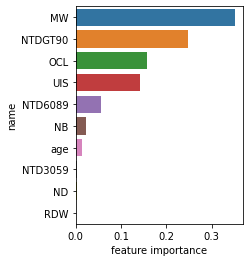

In [93]:
importance_features = pd.DataFrame.from_dict({'name':df.columns[1:], 'importance':rf_model.feature_importances_} )
importance_features.sort_values(by = 'importance', ascending=False)
fig = plt.figure(figsize = (3,4))
sns.barplot(data=importance_features.sort_values(by = 'importance', ascending=False), x='importance', y='name' )
plt.xlabel('feature importance')
plt.show()

A figure showing the feature importance is shown above. We can see that the most important variable in modeling is the MW (Monthly Wage), followed by NTDGT90 (Number of previous defaults above 90 days), OCL (OpenCredit Lines), UIS (Utilization of Insecure Credit Lines) and etc. 

---

# 5. Conclusion

* Random Forest Model with 400 trees with max depth of 4 levels was trained with a data set composed by 10 features;

* The training/testing data sets were divided in the proportion 0.8:0.2 respectively and SMOTE oversampling was applied in the less representative target class;

* The best threshold to classify default and non default clients was based in a business rule.

* The accuracy and recall metrics of the trained model in testing set are 0.86 and 0.64 respectively. Considering the proportion of defaults of 0.05, we can consider these metrics as fair.

* The most important features are the monthly wage, number of open credit lines and number of previous default greater than 90 days.